# Variance Forecasting: Generalized Auto-Regressive Conditional Heteroskedasticity (GARCH)

### What is ARCH(p)?
GARCH is the “ARMA equivalent” of ARCH, which only has an autoregressive component. GARCH models permit a wider range of behavior more persistent volatility and is an extension of the ARCH model that incorporates a moving average component together with the autoregressive component.

$ \epsilon (t) = w(t) * \sigma (t) $

$ \sigma(t)^2 = \alpha_0 + \sum_{i=1}^{q} \alpha_i \epsilon(t-i)^2 + \sum_{i=1}^{p} \beta_j \sigma(t-j)^2 $



### Why use ARCH?
Introduction of moving average component allows the model:
- To model the conditional change in variance over time.
- Changes in the time-dependent variance.

Examples include conditional increases and decreases in the variance.


### How to interpret ARCH?
- The large value of β1 causes σ(t) to be highly correlated with σ²(t−1) and gives the conditional standard deviation process a relatively long-term persistence, at least compared to its behavior under an ARCH model.
- For p = 0 the process reduces to the ARCH(q) process.
- For p = q = 0, ϵ(t) is simply white noise.

## Import libraries

In [1]:
pip install arch

     |████████████████████████████████| 875 kB 33.9 MB/s 
     |████████████████████████████████| 9.5 MB 52.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
plt.style.use("seaborn-whitegrid")

## Load data

In [6]:
# generate random data for ARCH(1)
y = np.array([np.random.normal(0, i*0.01, 1) for i in range(1, 101, 1)]).reshape(-1)

## Plot data (residuals)

In [7]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

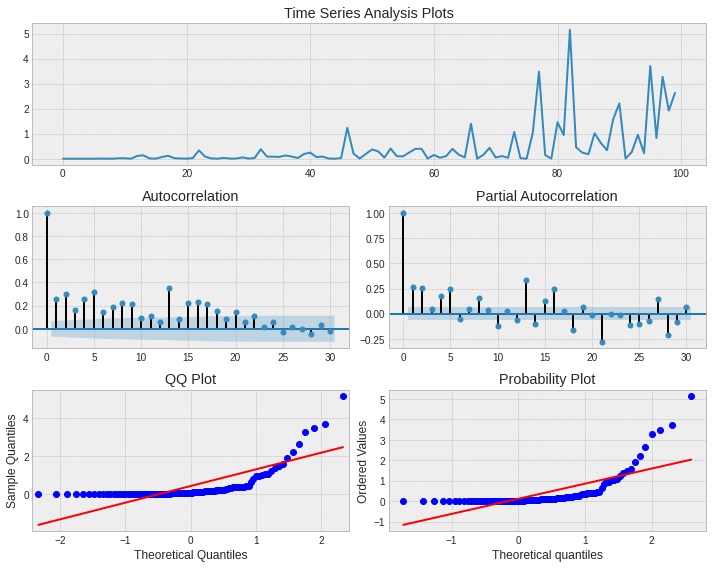

In [8]:
# squared residuals 
tsplot(np.square(y), lags=30)

Choosing p=17 might make a reasonable value for the parameter in the ARCH model.If a correlogram appears to be white noise, then volatility ca be detected by looking at the correlogram of the squared values since the squared values are equivalent to the variance (provided the series is adjusted to have a mean of zero). Let's also pick q=13. Note that, the dataset may not be a good fit for a GARCH model given the linearly increasing variance.

## Build GARCH Model

In [12]:
# split into train/test
n_test = 10
train = y[:-n_test]
test = y[-n_test:]

# define model
model = arch_model(train, mean="Zero", vol="GARCH", p=17, q=13)

# fit model
model_fit = model.fit()
print(model_fit.summary())

Iteration:      1,   Func. Count:     33,   Neg. LLF: 58.32905525982026
Iteration:      2,   Func. Count:     71,   Neg. LLF: 57.607593751643726
Iteration:      3,   Func. Count:    105,   Neg. LLF: 55.92548335727645
Iteration:      4,   Func. Count:    139,   Neg. LLF: 53.11891977016589
Iteration:      5,   Func. Count:    173,   Neg. LLF: 51.629744988187504
Iteration:      6,   Func. Count:    207,   Neg. LLF: 49.456595718156905
Iteration:      7,   Func. Count:    241,   Neg. LLF: 48.466376745507716
Iteration:      8,   Func. Count:    275,   Neg. LLF: 47.1430206357159
Iteration:      9,   Func. Count:    309,   Neg. LLF: 46.88224088692901
Iteration:     10,   Func. Count:    343,   Neg. LLF: 46.04519460531938
Iteration:     11,   Func. Count:    377,   Neg. LLF: 45.704671042647576
Iteration:     12,   Func. Count:    411,   Neg. LLF: 45.31512545024512
Iteration:     13,   Func. Count:    444,   Neg. LLF: 44.36217941839056
Iteration:     14,   Func. Count:    478,   Neg. LLF: 44.039

## Make Forecast

In [13]:
# forecast the test set
yhat = model_fit.forecast(horizon=n_test)
yhat.variance.values[-1:]

/usr/local/lib/python3.7/dist-packages/arch/__future__/_utility.py:21: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  FutureWarning,


array([[0.89615656, 1.02789014, 1.52037015, 0.83446991, 0.86492309,
        0.71530498, 1.54461877, 1.14053051, 0.65586159, 0.96956014]])

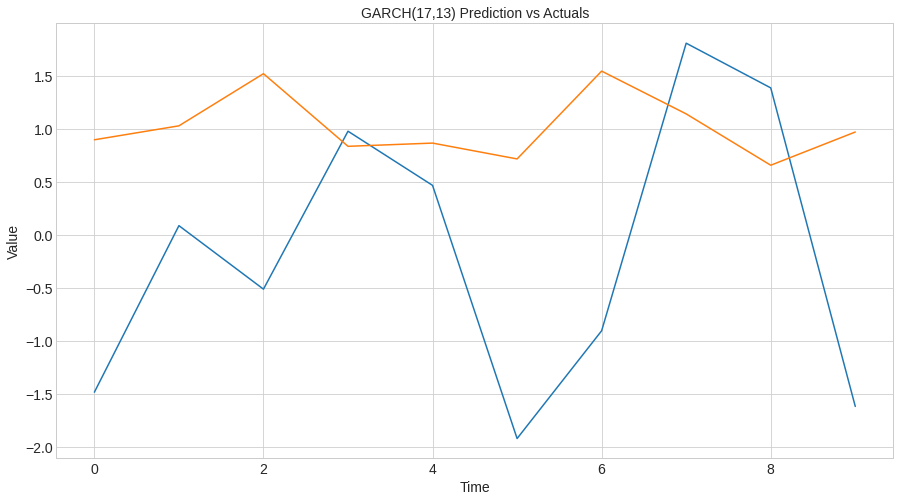

In [15]:
# plot predicted and actual values
plt.figure(figsize=(15,8))
plt.plot(test)
plt.plot(yhat.variance.values[-1:].reshape(-1))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title("GARCH(17,13) Prediction vs Actuals", fontsize=14)
plt.show()